In [51]:
import torch
import os
import glob
import uproot
from torch.utils.data import Dataset
import models
from utils import VBSConfig, print_title
from losses import DisCoLoss
from datasets import DisCoDataset
from train import get_outfile
from torch.utils.data import DataLoader
import numpy as np
import json

In [52]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"use_cuda: {use_cuda}")

use_cuda: False


In [53]:
config=VBSConfig.from_json("configs/Gaussians3D_noDisCo.json")
models_dir=f"{config.basedir}/trained_models"
test_datapath=get_outfile(config, tag="test_dataset")
test_datapath

'/home/users/joytzphysics/Analysis/abcdnet/trained_models/Gaussians3D_noDisCo_modelNeuralNetwork_nhidden4_hiddensize128_lr0.001_discolambda0_test_dataset.pt'

In [54]:
val_datapath=get_outfile(config,tag="val_dataset")
train_datapath=get_outfile(config,tag="train_dataset")

In [55]:
print(val_datapath)
print(train_datapath)

/home/users/joytzphysics/Analysis/abcdnet/trained_models/Gaussians3D_noDisCo_modelNeuralNetwork_nhidden4_hiddensize128_lr0.001_discolambda0_val_dataset.pt
/home/users/joytzphysics/Analysis/abcdnet/trained_models/Gaussians3D_noDisCo_modelNeuralNetwork_nhidden4_hiddensize128_lr0.001_discolambda0_train_dataset.pt


In [56]:
history=get_outfile(config,tag="history",ext="json")
print(history)
with open(history) as f:
    history_data = json.load(f)
print(history_data.keys())

/home/users/joytzphysics/Analysis/abcdnet/trained_models/Gaussians3D_noDisCo_modelNeuralNetwork_nhidden4_hiddensize128_lr0.001_discolambda0_history.json
dict_keys(['train_loss', 'test_loss', 'test_acc'])


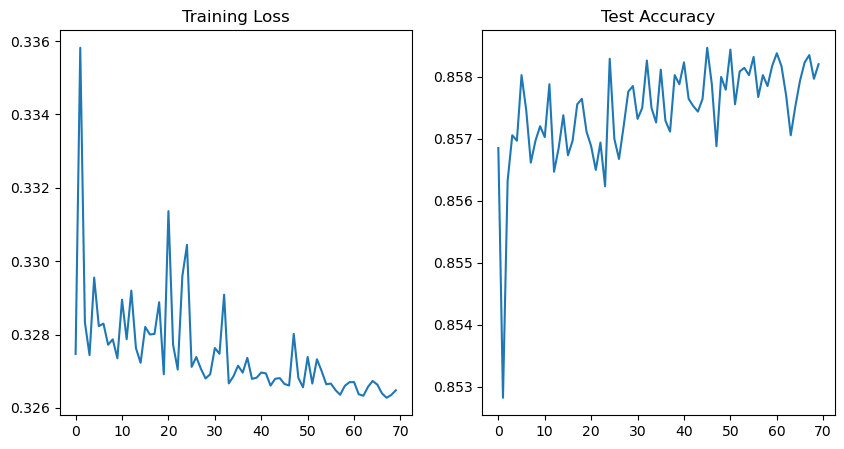

In [57]:
import matplotlib.pyplot as plt

# Assuming 'train_loss' and 'test_accuracy' are lists of float values
train_loss = history_data['test_loss']
test_accuracy = history_data['test_acc']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot training loss on the first subplot
ax1.plot(train_loss)
ax1.set_title('Training Loss')

# Plot test accuracy on the second subplot
ax2.plot(test_accuracy)
ax2.set_title('Test Accuracy')

# Show the plots
plt.show()

In [58]:
model_name="Gaussians3D_noDisCo_modelNeuralNetwork_nhidden4_hiddensize128_lr0.001_discolambda0_epoch70_model.pt"
model_path=os.path.join(models_dir,model_name)
Model=getattr(models, config.model.name)
model=Model.from_config(config).to(device)

----------------- Neural Network -----------------
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [59]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [60]:
test_data=test_data = DisCoDataset.from_files(
    test_datapath, 
    is_single_disco=(config.ingress.get("disco_target", None) != None)
)

In [61]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [62]:
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for batch_i, (features, labels, weights, disco_target) in enumerate(test_loader):
        # Load data
        output = model(features)
        y_pred_list.append(output.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

predicted_scores = np.concatenate(y_pred_list)
true_labels = np.concatenate(y_true_list)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)

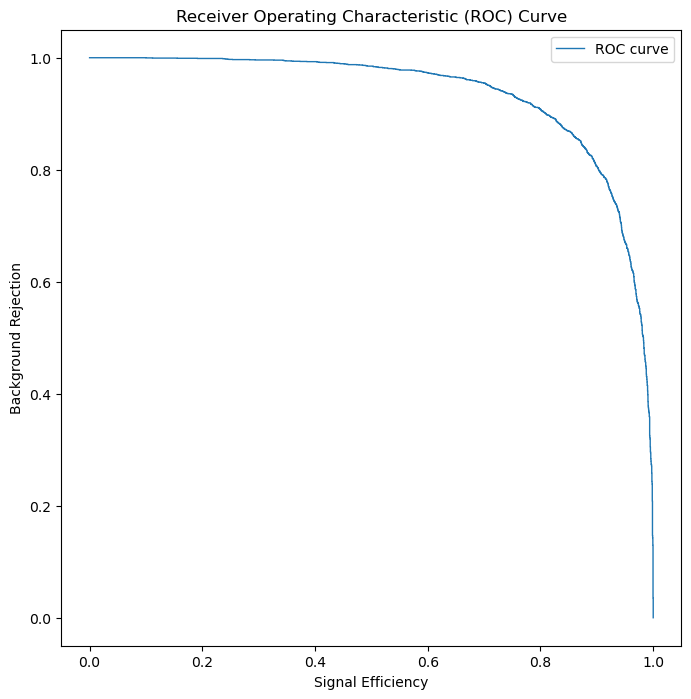

In [ ]:
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8, 8))
plt.plot(tpr, 1-fpr, lw=1, label='ROC curve')
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [ ]:
roc_auc

0.9355672777777777